# Milestone Project 2: SkimLit

This notebook is to group sectences in a medical abstract such that it becomes easier to read.

The paper I will be implementing is: https://arxiv.org/abs/1710.06071

The architecture for the paper is based on the paper found here: https://arxiv.org/abs/1612.05251

**NOTE:** This notebook was built and ran in Google Colab

In [1]:
## Confirm access to GPU (using NN)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e5c3723e-1931-7c50-ba27-6e94ed855952)


## Get data

I'll be using the same dataset produced by the authors of the PubMed 200k RCT paper. It is available via GitHub here: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
# Download the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.36 MiB/s, done.


In [3]:
# confirm data is present
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what data is in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# 20k dataset with numbers replaced with @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all of the filenames in the target dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [7]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Preprocess function to read in all of the lines of the text files.

In [8]:
# Create function to read lines of document

def get_lines(filename):
  
  """
  Reads filename and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [9]:
# read in training data
filename = "train.txt"
train_lines = get_lines(data_dir + filename)
train_lines[:27] # first 10

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
# preprocessing function to turn each dataset into the above format

def preprocess_text_with_line_numbers(filename):
  """
  Returns:
    List of dictionaries of abstract line data.

  Args:
    filename - the filepath and filename of a file
  """
  input_lines = get_lines(filename) # get all lines from file
  abtract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # new abstract is starting
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # this finds the newline character at the end of each abstract in the dataset
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0].lower()
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number # the line number where the sentence appears
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

CPU times: user 422 ms, sys: 94.4 ms, total: 516 ms
Wall time: 523 ms


In [12]:
# check lengths of each variable
print(len(test_samples))
print(len(train_samples))
print(len(val_samples))

30135
180040
30212


In [13]:
# check the first abstract of training data
train_samples[:15] # we see it moves on to the next abstract by looking at the line number being reset to 0

[{'target': 'objective',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'methods',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'methods',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'methods',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'methods',
  'text': 'secondary outcome measures included the western ontari

In [14]:
# Going to turn the data into Pandas DataFrames
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,objective,to investigate the efficacy of @ weeks of dail...,0,11
1,methods,a total of @ patients with primary knee oa wer...,1,11
2,methods,outcome measures included pain reduction and i...,2,11
3,methods,pain was assessed using the visual analog pain...,3,11
4,methods,secondary outcome measures included the wester...,4,11
5,methods,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,results,there was a clinically relevant reduction in t...,6,11
7,results,the mean difference between treatment arms ( @...,7,11
8,results,"further , there was a clinically relevant redu...",8,11
9,results,these differences remained significant at @ we...,9,11


In [15]:
# distribution of labels to check for imbalances
train_df.target.value_counts()

methods        59353
results        57953
conclusions    27168
background     21727
objective      13839
Name: target, dtype: int64

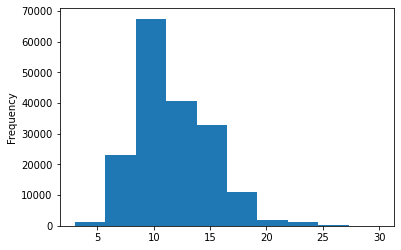

In [16]:
# length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [17]:
# Convert abstract text lines into list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the first 10 lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numberic labels

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what the encoding looks like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [163]:
len(val_labels_encoded)

30212

In [21]:
# get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['background', 'conclusions', 'methods', 'objective', 'results'],
       dtype=object))

## Experiements start here

## Mode 0: Getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-31 00:36:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 00:36:03 (86.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
from helper_functions import calculate_results

In [27]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the text for models

Need to create vectorization and embedding layers

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# Average length of sentences
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sentence_lengths)

avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

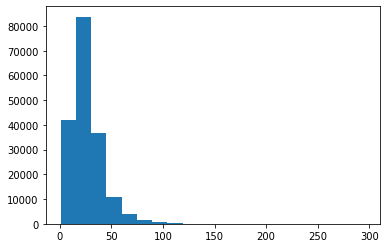

In [30]:
# check distribution
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=20)

> The majority of sentences are less than 50, calculate a value that includes 95% of the data

In [31]:
# how long of a sentence includes 95% of the examples
output_seq_len = int(np.percentile(sentence_lengths, 95))
output_seq_len

55

> length of 55 includes 95% of the dataset

In [32]:
# max length in training set
max(sentence_lengths)

296

### Create text vectorizer layer

Maps words into numbers (indexes for each word in vocabulary)

In [33]:
# How many words are in vocab? (taken from paper: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [34]:
# create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequence

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 sarcopenia is a defining feature of cancer cachexia associated with physical decline , poor quality of life and poor prognosis .

Length of text: 21

Vectorized text: [[11411    20     8  8481  5080     4   135 12779    81     7   189  1078
    716   141     4   195     3   716  1865     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


> word count of 26 in the example above, padded up to the prescribed 55

In [37]:
# How many words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# get the confifg of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=(len(rct_20k_text_vocab)),
                               output_dim=128, # the length of the vector used to represent the word 
                               mask_zero=True, # use masking to handle variable sequence lengths (efficient computing when there are many padding zeros)
                               name="token_embedding")

In [40]:
# show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n") # raw text
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n") # tokenized sentence represented by word indexes from the full vocab
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}") # the sentence, represented as a series of feature vectors that represent the sentence
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 sarcopenia is a defining feature of cancer cachexia associated with physical decline , poor quality of life and poor prognosis .

Sentence after vectorization (before embedding):
 [[11411    20     8  8481  5080     4   135 12779    81     7   189  1078
    716   141     4   195     3   716  1865     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.0338718  -0.0125298  -0.00698153 ... -0.03775914 -0.02356618
   -0.03507528]
  [ 0.02494467 -0.04484935  0.02434777 ... -0.00235915 -0.03233087
    0.00770972]
  [ 0.04362993  0.03961331 -0.04724848 ... -0.02875646  0.00857387
   -0.03583877]
  ...
  [-0.00229485 -0.00921875  0.00176682 ... -0.00177862  0.0029683
   -0.01870368]
  [-0.00229485 -0.00921875  0.00176682 ... -0.00177862  0.0029683
   -0.01870368]

> 1 sequence (sentence), has a static quantity of 55 tokens (words) represented as numbers (indexes derived from the vectorizer). Each token is turned into a 128-length feature vector (embedding) that can be trained.

## Creating datasets using tf.data API to optimize

* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance

In [41]:
# Turn the data into TensorFlow datasets to make it load as efficiently as possible
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [42]:
# take a look at the train dataset
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Convert TensorSliceDataset into prefetch datasets to improve the preloading of data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE for prefetch says to use the highest quantity of samples possible
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
# check the train_dataset
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

To understand convolutional neural networks and that activities that occur to calculate import features, see this article: https://iq.opengenus.org/convolution-filters/

In [45]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize the text inputs
token_embeddings = token_embed(text_vectors) # create embedding of the tokens
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x) # softmax is optimal for multiclass (greater than 2)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [47]:
# fit the model
history_model_1 = model_1.fit(train_dataset, # this is a tuple so you don't need to pass train data and labels
                              steps_per_epoch=int(0.1 * len(train_dataset)), # limit the amount of data to speed up this first experiment
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # test on only 10% of the data

Epoch 1/3
562/562 [==============================] - 13s 9ms/step - loss: 0.9185 - accuracy: 0.6321 - val_loss: 0.6855 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6557 - accuracy: 0.7559 - val_loss: 0.6261 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6163 - accuracy: 0.7751 - val_loss: 0.5954 - val_accuracy: 0.7862


In [48]:
# evaluate on the full dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5972 - accuracy: 0.7862


[0.5972219705581665, 0.7862107753753662]

In [49]:
# make predictions (makes predictions for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.53640223e-01, 1.43525407e-01, 9.12415236e-02, 2.85020262e-01,
         2.65726075e-02],
        [4.57174301e-01, 2.54752815e-01, 1.52579518e-02, 2.63468564e-01,
         9.34633892e-03],
        [1.71180412e-01, 7.06903823e-03, 1.42636732e-03, 8.20248067e-01,
         7.62067721e-05],
        ...,
        [2.16418198e-06, 5.43201691e-04, 3.11011914e-04, 1.17393506e-06,
         9.99142408e-01],
        [6.50004894e-02, 4.66141105e-01, 1.17383346e-01, 6.99935481e-02,
         2.81481534e-01],
        [1.79397836e-01, 6.64967299e-01, 4.63202186e-02, 4.94067222e-02,
         5.99079430e-02]], dtype=float32), (30212, 5))

> Notice a shape of 5, this is the quantity of classes for this multiclass problem. To understand the maximum prediction (the models decision on what is the highest probability of truth) for a given class we need to find the maximum value

In [50]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
class_names

array(['background', 'conclusions', 'methods', 'objective', 'results'],
      dtype=object)

In [52]:
# calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

In [53]:
# get results
model_1_results

{'accuracy': 78.62107771746327,
 'precision': 0.7831798540177454,
 'recall': 0.7862107771746326,
 'f1': 0.7837945032067961}

In [54]:
# compare to baseline
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction with Pretrained Token Embeddings

Using [USE (Universal Sentence Encoder)](https://tfhub.dev/google/universal-sentence-encoder/4) from TensorFlow Hub. Paper used [GloVe](https://github.com/GradySimon/tensorflow-glove) in 2016, USE is more recent.

In [55]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [56]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}") # truncated to save space
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}") # represented as a matrix with one feature vector inside, indexing at 0 to see the length of that feature vector

Random Sentence:
 ards is a heterogeneous syndrome that encompasses lung injury from both direct and indirect sources .
Sentence after embedding:
 [ 0.03253933  0.04708017 -0.01922449  0.07235873  0.07130293 -0.02522189
  0.01827033 -0.05095265  0.06443859  0.04327937  0.08298972 -0.02292503
 -0.02958709  0.05055273 -0.01887251 -0.0806471  -0.08123197  0.03096957
 -0.03901139  0.00081724  0.01828263  0.03871792  0.03919617 -0.03694986
 -0.03578462 -0.02558818 -0.00290775 -0.07548501 -0.06256166 -0.00996574]
Length of sentence embedding: 512


## Building and fitting the NLP feature extraction model using TensorFlow Hub

In [57]:
# define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string) # the shape list that is empty is for arbitrary length lists
pretrained_embedding = tf_hub_embedding_layer(inputs) # this feature extraction model converts them into 512 feature vectors
x = layers.Dense(128, activation="relu")(pretrained_embedding) # converts each embedding into a one dimensional feature vector of arbitrary length (128 in this case)
outputs = layers.Dense(num_classes, activation="softmax")(x) # output with length num_classes for output layer to match number of possible classes
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [59]:
# fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9165 - accuracy: 0.6513 - val_loss: 0.7973 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7702 - accuracy: 0.7018 - val_loss: 0.7562 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7528 - accuracy: 0.7120 - val_loss: 0.7404 - val_accuracy: 0.7114


In [60]:
# evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7432 - accuracy: 0.7132


[0.7432200312614441, 0.7131603360176086]

In [61]:
# make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.2332831e-01, 3.6369780e-01, 1.8611973e-03, 2.0203935e-01,
        9.0733515e-03],
       [3.4377861e-01, 4.9308461e-01, 3.3351446e-03, 1.5621725e-01,
        3.5843975e-03],
       [2.6722357e-01, 1.5235022e-01, 1.6881438e-02, 5.2232939e-01,
        4.1215360e-02],
       ...,
       [1.8255423e-03, 6.2055625e-03, 5.4668795e-02, 9.2013815e-04,
        9.3638003e-01],
       [4.0052854e-03, 4.1611470e-02, 2.0417321e-01, 1.5975749e-03,
        7.4861240e-01],
       [2.0585862e-01, 2.5318325e-01, 4.7842309e-01, 5.9426040e-03,
        5.6592427e-02]], dtype=float32)

In [62]:
# conver the prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [63]:
# calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

In [64]:
model_2_results

{'accuracy': 71.31603336422614,
 'precision': 0.7143198668292993,
 'recall': 0.7131603336422614,
 'f1': 0.7102697294134336}

In [65]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

Paper that I'm replicating used combination of token and character-level embeddings.

### Create character level tokenizer

In [66]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# test splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'a r d s   i s   a   h e t e r o g e n e o u s   s y n d r o m e   t h a t   e n c o m p a s s e s   l u n g   i n j u r y   f r o m   b o t h   d i r e c t   a n d   i n d i r e c t   s o u r c e s   .'

In [67]:
# split sequence-level data splits into cahracter-leve data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [68]:
# what's the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

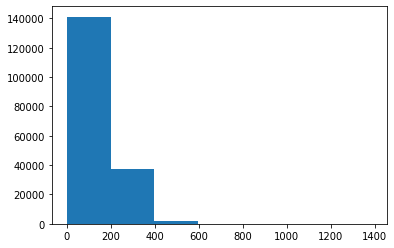

In [69]:
# check the distribution of sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [70]:
# what length of characters covers 95% of all cases
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

> 95% of all character counts falls within 290 characters

In [71]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# find the length of all keyboard characters
len(alphabet)

68

In [73]:
# create char-level vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add two to include space and the 'UNKNOWN' token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardization=None, # uncomment if you want to leave all punctuation in the text, otherwise everything is lowercase and the punctuation is stripped
                                    name="char_vectorizer")

In [74]:
# adapt the vectorizer to the training characters
char_vectorizer.adapt(train_chars)

In [75]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in the character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in the character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [76]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Char text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Char text:
 p a t i e n t s   a r e   r a n d o m l y   a s s i g n e d   t o   e i t h e r   c e f t r i a x o n e   a t   a   d o s e   o f   @   g   ,   g i v e n   e v e r y   @   h   i n t r a v e n o u s l y   f o r   @   d a y s   ,   i n   a d d i t i o n   t o   s t a n d a r d   s t r o k e - u n i t   c a r e   ,   o r   s t a n d a r d   s t r o k e - u n i t   c a r e   w i t h o u t   p r e v e n t i v e   a n t i b i o t i c   t h e r a p y   .

Length of random_train_chars: 188

Vectorized chars:
 [[14  5  3  4  2  6  3  9  5  8  2  8  5  6 10  7 15 12 19  5  9  9  4 18
   6  2 10  3  7  2  4  3 13  2  8 11  2 17  3  8  4  5 24  7  6  2  5  3
   5 10  7  9  2  7 17 18 18  4 21  2  6  2 21  2  8 19 13  4  6  3  8  5
  21  2  6  7 16  9 12 19 17  7  8 10  5 19  9  4  6  5 10 10  4  3  4  7
   6  3  7  9  3  5  6 10  5  8 10  9  3  8  7 23  2 16  6  4  3 11  5  8
   2  7  8  9  3  5  6 10  5  8 10  9  3  8  7 23  2 16  6  4  3 11  5  8
   2 20  4  3 13  7 16  3 14  8  2 21

## Creating a character level embedding

In [77]:
char_embed = layers.Embedding(input_dim=len(char_vocab), # size of the vocab
                              output_dim=25, # size of the char embedding in the paper, figure 1
                              mask_zero=True,
                              name="char_embed")

In [78]:
# Test out character embedding layer
print(f"charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"\nEmbedded chars:\n  {char_embed_example}\n")
print(f"\nCharacter embedding shape:\n {char_embed_example.shape}")

charified text:
 p a t i e n t s   a r e   r a n d o m l y   a s s i g n e d   t o   e i t h e r   c e f t r i a x o n e   a t   a   d o s e   o f   @   g   ,   g i v e n   e v e r y   @   h   i n t r a v e n o u s l y   f o r   @   d a y s   ,   i n   a d d i t i o n   t o   s t a n d a r d   s t r o k e - u n i t   c a r e   ,   o r   s t a n d a r d   s t r o k e - u n i t   c a r e   w i t h o u t   p r e v e n t i v e   a n t i b i o t i c   t h e r a p y   .

Embedded chars:
  [[[-2.5512910e-02 -1.1415850e-02  3.0445684e-02 ...  2.9389445e-02
    3.7933674e-02 -4.6178818e-02]
  [-1.8951356e-02 -3.4934640e-02 -1.4786195e-02 ...  2.7879361e-02
   -4.8797965e-02  3.4443859e-02]
  [ 9.4416626e-03  4.3870244e-02 -4.3459963e-02 ... -2.0445809e-03
   -4.0232312e-02  4.7736738e-02]
  ...
  [ 8.9526176e-05 -1.0533832e-02 -2.8468156e-02 ... -1.4313959e-02
   -3.7517667e-02 -3.6864579e-02]
  [ 8.9526176e-05 -1.0533832e-02 -2.8468156e-02 ... -1.4313959e-02
   -3.7517667e-02 -3.6864579e-02]
 

> 1 sequence (sentence), statically defined each sentence to be no more or less than 290 characters, each character is converted into an embedding/feature vector of length 25

### Building Conv1D model to fit on character embeddings

In [79]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

# compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [80]:
# summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [81]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2705 - accuracy: 0.4808 - val_loss: 1.0494 - val_accuracy: 0.5831
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0116 - accuracy: 0.5974 - val_loss: 0.9493 - val_accuracy: 0.6270
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9382 - accuracy: 0.6328 - val_loss: 0.8839 - val_accuracy: 0.6556


In [83]:
# make predictions with character model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.18787715, 0.33743823, 0.07864026, 0.28662995, 0.10941441],
       [0.20789637, 0.28791314, 0.03607093, 0.29349452, 0.17462502],
       [0.18853769, 0.28794312, 0.14765728, 0.26275006, 0.11311185],
       ...,
       [0.01223032, 0.02629418, 0.16202065, 0.01017875, 0.7892761 ],
       [0.05752125, 0.24446926, 0.27357924, 0.13107195, 0.29335824],
       [0.6557408 , 0.23428959, 0.03258153, 0.07264223, 0.00474585]],
      dtype=float32)

In [84]:
# convert pred probs to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 1, ..., 4, 4, 0])>

In [85]:
# calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

In [86]:
model_3_results

{'accuracy': 65.13636965444194,
 'precision': 0.6438941292032287,
 'recall': 0.6513636965444194,
 'f1': 0.639870888020869}

In [87]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embeddings (multimodal)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [the paper](https://arxiv.org/abs/1710.06071). (Deviating from the use of SGD in favor of Adam)
5. Construct a model that takes token and character-level sequences as input and produces sequence label probabilities as output

In [88]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in fig 1 of the paper, shifted the LSTM neurons to 24 to have multiples of 8
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="char_model")

# 3. Concat token and char inputs (hybrid embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout layer, shown in 4.2 for the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat) # regularization tool to drop a given ratio of patterns, in this case 50% of them randomly to avoid overfitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embedding")

In [89]:
# summary
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

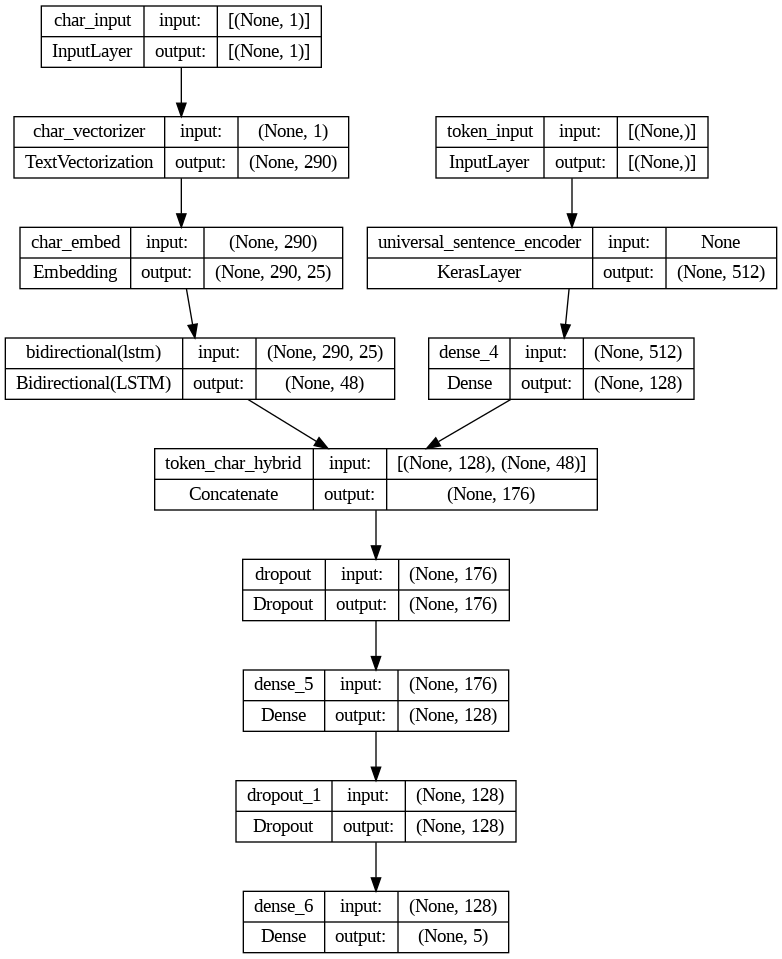

In [90]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [91]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # paper uses SGD
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` Dataset

In [92]:
# Combine chars adn tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels)) # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Combine chars adn tokens into a dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels)) # combine data and labels

# prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# check out training char and token dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting model on token and char-level sequences

In [95]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 57ms/step - loss: 0.9842 - accuracy: 0.6063 - val_loss: 0.7793 - val_accuracy: 0.7031
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8076 - accuracy: 0.6899 - val_loss: 0.7190 - val_accuracy: 0.7217
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7804 - accuracy: 0.6998 - val_loss: 0.6951 - val_accuracy: 0.7330


In [96]:
# evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6968 - accuracy: 0.7335


[0.6967573165893555, 0.7334502935409546]

In [97]:
# make predictions using the token-char hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[4.0445173e-01, 3.7763783e-01, 4.7209365e-03, 2.0764400e-01,
        5.5454820e-03],
       [3.2216603e-01, 5.1594466e-01, 3.3509294e-03, 1.5684998e-01,
        1.6884414e-03],
       [2.4639823e-01, 1.1863904e-01, 3.7516952e-02, 5.5255210e-01,
        4.4893742e-02],
       ...,
       [4.3499743e-04, 8.8258572e-03, 6.3300632e-02, 1.7337623e-04,
        9.2726517e-01],
       [4.5623984e-03, 4.2005900e-02, 2.2536269e-01, 2.1984060e-03,
        7.2587061e-01],
       [2.7801141e-01, 2.7240294e-01, 3.5658002e-01, 3.7833288e-02,
        5.5172328e-02]], dtype=float32)

In [98]:
# format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [99]:
# get results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [100]:
model_4_results

{'accuracy': 73.3450284655104,
 'precision': 0.7336418483984474,
 'recall': 0.733450284655104,
 'f1': 0.7298468883400628}

## Model 5: Transfer learning with pretrained token + char + positional embeddings

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,objective,to investigate the efficacy of @ weeks of dail...,0,11
1,methods,a total of @ patients with primary knee oa wer...,1,11
2,methods,outcome measures included pain reduction and i...,2,11
3,methods,pain was assessed using the visual analog pain...,3,11
4,methods,secondary outcome measures included the wester...,4,11


> **NOTE:** Any features engineered to train the model must be available at test time.

### Create positional embeddings

In [102]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

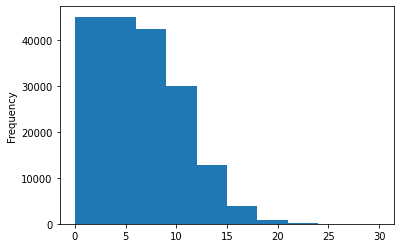

In [103]:
# check distribution of line number column
train_df.line_number.plot.hist()

In [104]:
# Create OneHot encoded values using 15 lines or lower, this covers the vast majority
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [105]:
# How many different total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

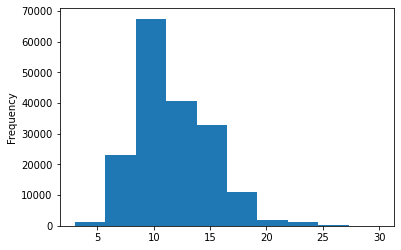

In [106]:
# check distribution
train_df["total_lines"].plot.hist()

> Super majority of abstracts fall within 20 lines.

In [107]:
# Check coverge using percentile method on total lines
np.percentile(train_df.total_lines, 95)

18.0

In [108]:
# Create onehot encoded tensors of total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building the multi-input model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the line number feature
4. Create a model for the total lines feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a `tf.keras.Model`

In [131]:
train_line_numbers_one_hot[0].dtype

tf.float32

In [139]:
# 1. Token Inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char Inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
# char_dropout = layers.Dropout(0.5)(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input") # 15 to match the static length defined earlier
x = layers.Dense(32, activation="relu")(line_number_inputs) # output layer
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total Lines Model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
combined_embeddings_output_layer = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(combined_embeddings_output_layer)

# 6. Combine positional embedding with combined token and char embedding
combined_again_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                        total_lines_model.output,
                                                                                        z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(combined_again_embeddings)

# 8. Put together model with all inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5")

In [140]:
# summary
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

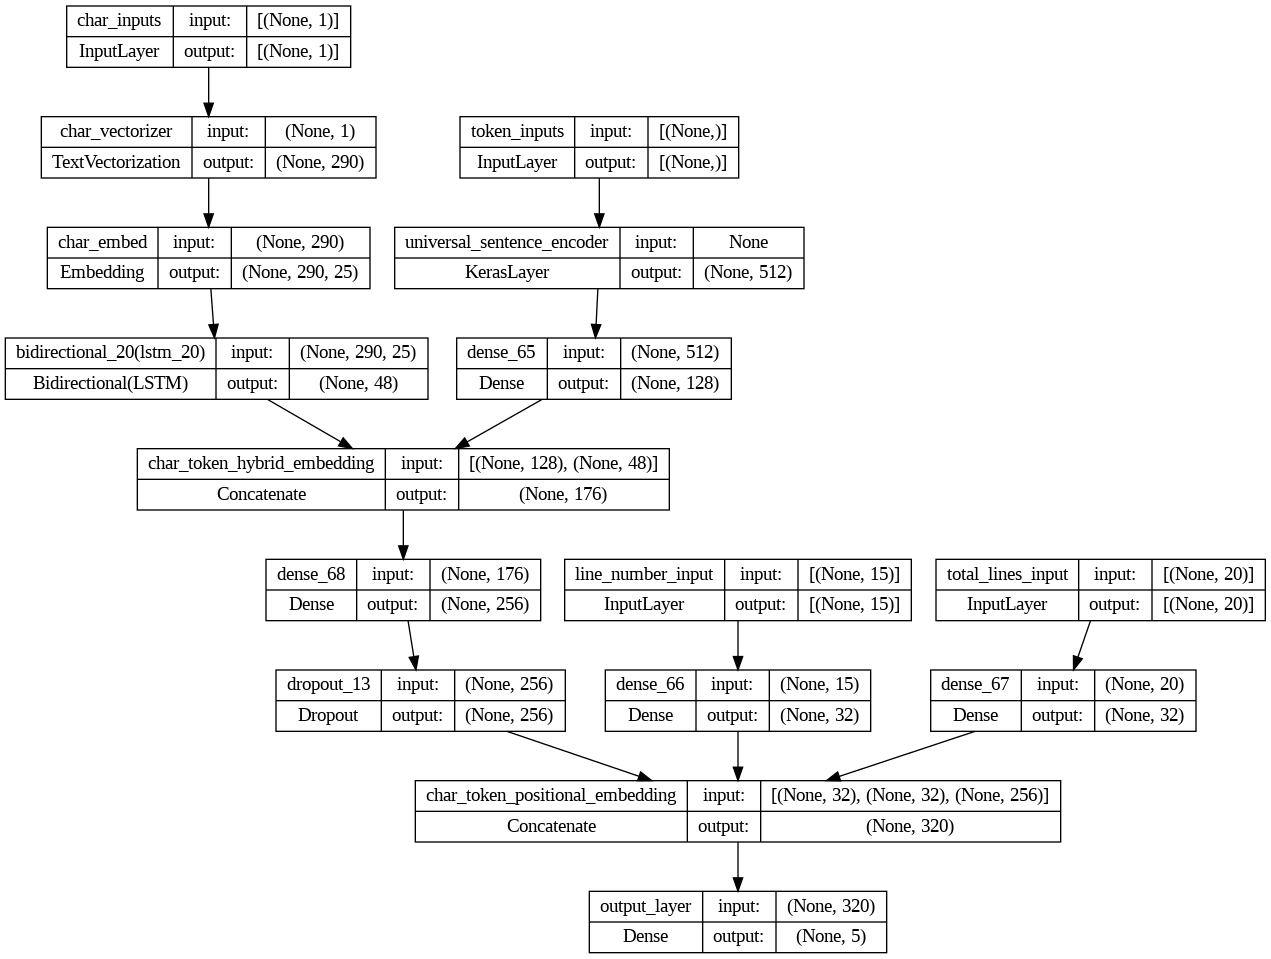

In [145]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [146]:
# compile token char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create datasets for model 5

In [153]:
# Create training and validation datasets with all 4 kinds of input
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# do same as above for val dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, train_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [154]:
# check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [155]:
# fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 63s 97ms/step - loss: 1.0965 - accuracy: 0.7235 - val_loss: 0.9651 - val_accuracy: 0.8144
Epoch 2/3
562/562 [==============================] - 51s 91ms/step - loss: 0.9642 - accuracy: 0.8172 - val_loss: 0.9445 - val_accuracy: 0.8269
Epoch 3/3
562/562 [==============================] - 39s 70ms/step - loss: 0.9485 - accuracy: 0.8254 - val_loss: 0.9384 - val_accuracy: 0.8324


In [164]:
model_4_results

{'accuracy': 73.3450284655104,
 'precision': 0.7336418483984474,
 'recall': 0.733450284655104,
 'f1': 0.7298468883400628}